# Cigarette Smoking Rates Across Age Groups in NYC (2002-2017)

#### by Anika Kumbhakar
#### email: agk329@stern.nyu.edu

NYC has long been considered a city at the forefront of progress in public health. In recent years, it has taken significant steps to reduce smoking and the health issues for all that result from it, like the Clean Air Act that banned smoking in indoor public spaces, and some of the highest minimum cigarette prices in the country. This project aims to study the change in smoking rates for different age groups over the period 2002-2017. I will use data from [New York City's Community Health Survey (CHS)](https://www1.nyc.gov/site/doh/data/data-sets/community-health-survey-public-use-data.page), which is taken annually by the City Department of Health and Mental Hygiene since 2002. I will also use cigarette price data from the CDC- ["The Tax Burden on Tobacco,
1970-2017"(Orzechowski and Walker)](https://chronicdata.cdc.gov/Policy/The-Tax-Burden-on-Tobacco-1970-2017/7nwe-3aj9/data). The results of this project will show how smoking rates and average number of cigarettes smoked have changed in different age groups and and whether there is any relationship between that change and the average price of a pack of cigarettes. 

This project has two components: 
- Basic statistics showing the percentage of smokers and average number of cigarettes for each age group (18-24 yrs, 25-44 yrs, 45-64 yrs, and 65+ yrs) 
- Graphs showing the relationship between those statistics over time and the price of cigarettes.

### Data Overview: 
The data for this project comes from the CHS, as stated above. The survey includes a variety of demographic and health data for respondents across NYC. 
I also will use CDC data on the average price of cigarettes by state. The dataset contains the yearly average price for every state. 

### Variables: 
Below, I will import the CHS just for 2017 to demonstrate how I'll get the data on who smokes, how much they smoke, and what age group they are in. For aggregating this data, I will use the provided survey weights to calculate accurate population estimates.

   The variables that I will be using from the CHS:
   - "Age Group": the CHS categorizes 4 age groups, coded as 1.0 through 4.0. (18-24 yrs, 25-44 yrs, 45-64 yrs, and 65+ yrs)
   - "Everyday Smoker": coded as 1 for "Yes, Every Day" and 2 for "No, Some Days"
   - "Cigs per Day": # of cigs smoked per day for every & someday smokers
   - survey weight variable: each response is attached a weight that is used to obtain full population estimates

Variables from CDC: 
   
   
   -  Yearly average cigarette price across New York State
   
   Note: NYC has an additional tax on cigarettes, so the NYS prices may be slightly lower than NYC. 

### CHS Data: 

Below, I have imported the necessary packages for this project, notably weightedcalc, which will be used to do calculations using survey weights.

In [447]:
import pandas as pd
import matplotlib.pyplot as plt
import weightedcalcs as wc
import numpy as np

Below, I will walk through how to manipulate the CHS to get the weighted variables we need. First, I will read in the file and create a dataframe that contains only the specified variables that are needed. 

In [448]:
#looking at 2017 New York City Community Health Survey
url = "https://www1.nyc.gov/assets/doh/downloads/sas/episrv/chs2017_public.sas7bdat"
#codebook url: https://www1.nyc.gov/assets/doh/downloads/pdf/episrv/chs2017-codebook.pdf
df2017 = pd.read_sas(url)

In [449]:
df2017 = df2017[["smoker", "numberperdaya", "agegroup","wt18_dual"]]
df2017["Year"] = 2017
df2017.rename(columns={"smoker":"Everyday Smoker", "numberperdaya":"Cigs per Day", "agegroup": "Age Group"}, inplace = True)

The first thing we are looking for is the percentage of the population in each age group that smokes. So first, I will find the total (weighted) number of smokers in each age group.

To use the weightedcalc package, we have to specify the variable that contains the survey weights, in this case, "wt18_dual". 

In [450]:
calc = wc.Calculator("wt18_dual")

In [451]:
calc

Because we want the weighted total population of each age group, we first group by the age groups and then use the weightedcalc function calc.count to get the weighted counts. 

In [452]:
agegroup = df2017.groupby(["Age Group"])

In [453]:
x = calc.count(agegroup)

In [454]:
x

Age Group
1.0    8.545056e+05
2.0    2.614480e+06
3.0    2.069035e+06
4.0    1.003238e+06
dtype: float64

We use the to_frame() function to put our results in a dataframe.

In [455]:
ag_df = x.to_frame()

In [456]:
#ag_df

In [457]:
ag_df.columns = ["Total Count 2017"] #title for column 

In [458]:
ag_df

,Total Count 2017
Age Group,
1.0,8.545056e+05
2.0,2.614480e+06
3.0,2.069035e+06
4.0,1.003238e+06


Then, we want the part of the population that smokes every day. According to CHS coding, that is when the "Everyday Smoker" variable is 2.0. 

In [459]:
smokers = df2017[df2017["Everyday Smoker"] == 2.0]

In [460]:
smokers_agegroup = smokers.groupby(["Age Group"])

In [461]:
x = calc.count(smokers_agegroup)

In [462]:
ag_smokers_df = x.to_frame()
ag_smokers_df.columns = ["Smoker Count 2017"]

In [463]:
ag_df = ag_df.join(ag_smokers_df) #add the new dataframe to the previous

We add this new column to the dataframe and get: 

In [464]:
ag_df

,Total Count 2017,Smoker Count 2017
Age Group,,
1.0,8.545056e+05,73047.165813
2.0,2.614480e+06,407211.117274
3.0,2.069035e+06,319511.575450
4.0,1.003238e+06,81331.522975


Then, we can easily create a new column that shows the fraction of each age group that smokes.

In [465]:
ag_df["% Smokers 2017"] = (ag_df["Smoker Count 2017"]/ag_df["Total Count 2017"])*100

In [466]:
ag_df

,Total Count 2017,Smoker Count 2017,% Smokers 2017
Age Group,,,
1.0,8.545056e+05,73047.165813,8.548471
2.0,2.614480e+06,407211.117274,15.575224
3.0,2.069035e+06,319511.575450,15.442538
4.0,1.003238e+06,81331.522975,8.106906


We also want to find the average cigarettes per day for everyday smokers in each age group. This is done using the calc.mean function, since we want to average the number across the weighted age group. 

In [467]:
x = calc.mean(smokers_agegroup, "Cigs per Day")

In [468]:
ag_cpd_df = x.to_frame()
ag_cpd_df.columns = ["Cigs per Day 2017"]
ag_df = ag_df.join(ag_cpd_df)

In [469]:
ag_df

,Total Count 2017,Smoker Count 2017,% Smokers 2017,Cigs per Day 2017
Age Group,,,,
1.0,8.545056e+05,73047.165813,8.548471,5.567746
2.0,2.614480e+06,407211.117274,15.575224,7.033153
3.0,2.069035e+06,319511.575450,15.442538,9.488739
4.0,1.003238e+06,81331.522975,8.106906,9.214358


Now, we have a dataset that has all the information we need from the CHS.

### Scaling it up: 

I created a function that will read in and process each year's CHS, including those for 2005 and 2007 that do not have data for "Cigs per Day". After being read in, I pull only the necessary data into a dataframe for each file- "Everyday Smoker", "Cigs per Day", "Age Group", and the file's respective weight variable. I then use the process outlined above to add the relevant calculated data to one dataframe.

In [470]:
def read_in(url, weight_var, year): #require weight variable as an input because the variable name changes from year to year 
    df = pd.read_sas(url) #read sas file from link 
    
    if 'numberperdaya' in df.columns:
        df = df[["smoker", "numberperdaya", "agegroup", weight_var]] #only working with these 4 variables
        df["Year"] = year #add year as a column
        #rename columns
        df.rename(columns={"smoker":"Everyday Smoker", "numberperdaya":"Cigs per Day", "agegroup": "Age Group"}, inplace = True)

        calc = wc.Calculator(weight_var) #set weight variable to use in calculator package 
        sc = "Smoker Count "
        tc = "Total Count " 


        agegroup = df.groupby(["Age Group"]) #group data by age groups
        x = calc.count(agegroup) #creates weighted count of all responses to use as the base population
        ag_df = x.to_frame() #add to dataframe
        ag_df.columns = ["Total Count "]
        smokers = df[df["Everyday Smoker"] == 2.0] #only select responses where responded smokes every day
        smokers_agegroup = smokers.groupby(["Age Group"])
        y = calc.count(smokers_agegroup) #weighted count of population who smokes every day
        ag_smokers_df = y.to_frame()
        ag_smokers_df.columns = [sc]
        ag_df = ag_df.join(ag_smokers_df) #add to dataframe
        ag_df["% Smokers "] = (ag_df[sc]/ag_df[tc])*100 #percentage of smokers out of base population
        z = calc.mean(smokers_agegroup, "Cigs per Day") #average cigs per day for each agegroup
        ag_cpd_df = z.to_frame()
        ag_cpd_df.columns = ["Cigs per Day "]
        ag_df = ag_df.join(ag_cpd_df) #add to dataframe
        ag_df["Year"] = year

        ag_df.set_index("Year", append=True, inplace=True) #set year as second index
        
    #following else statement is for 2005 and 2007 datasets where "Cigs per Day" data was not collected
    else: 
        df = df[["smoker", "agegroup", weight_var]]
        df["Year"] = year
        df.rename(columns={"smoker":"Everyday Smoker", "agegroup": "Age Group"}, inplace = True)
    
        calc = wc.Calculator(weight_var)
        sc = "Smoker Count "
        tc = "Total Count " 


        agegroup = df.groupby(["Age Group"])
        x = calc.count(agegroup)
        ag_df = x.to_frame()
        ag_df.columns = ["Total Count "]
        smokers = df[df["Everyday Smoker"] == 2.0]
        smokers_agegroup = smokers.groupby(["Age Group"])
        y = calc.count(smokers_agegroup)
        ag_smokers_df = y.to_frame()
        ag_smokers_df.columns = [sc]
        ag_df = ag_df.join(ag_smokers_df)
        ag_df["% Smokers "] = (ag_df[sc]/ag_df[tc])*100
        ag_df["Year"] = year

        ag_df.set_index("Year", append=True, inplace=True)
    return ag_df


In [471]:
part1_df = pd.DataFrame([]) #create empty dataframe

Below, each year's CHS is appended to the empty dataframe. While it would be more elegant to read in each file through a loop, the survey weight variable names change each year and so the appending must be done individually. I looked up each year's respective survey weight name in its codebook, which can also be found through the CHS public use data link provided above. 

In [472]:
part1_df = part1_df.append(read_in("https://www1.nyc.gov/assets/doh/downloads/sas/episrv/chs2017_public.sas7bdat", "wt18_dual", 2017))

In [473]:
part1_df = part1_df.append(read_in("https://www1.nyc.gov/assets/doh/downloads/sas/episrv/chs2016_public.sas7bdat", "wt17_dual", 2016))

In [474]:
part1_df = part1_df.append(read_in("https://www1.nyc.gov/assets/doh/downloads/sas/episrv/chs2015_public.sas7bdat", "wt16_dual", 2015))

In [475]:
part1_df = part1_df.append(read_in("https://www1.nyc.gov/assets/doh/downloads/sas/episrv/chs2014_public.sas7bdat", "wt15_dual", 2014))

In [476]:
part1_df = part1_df.append(read_in("https://www1.nyc.gov/assets/doh/downloads/sas/episrv/chs2013_public.sas7bdat", "wt14_dual", 2013))

In [477]:
part1_df = part1_df.append(read_in("https://www1.nyc.gov/assets/doh/downloads/sas/episrv/chs2012_public.sas7bdat", "wt13_dual", 2012))

In [478]:
part1_df = part1_df.append(read_in("https://www1.nyc.gov/assets/doh/downloads/sas/episrv/chs2011_public.sas7bdat", "wt12_dual", 2011))

In [479]:
part1_df = part1_df.append(read_in("https://www1.nyc.gov/assets/doh/downloads/sas/episrv/chs2010_public.sas7bdat", "wt11_dual", 2010))

In [480]:
part1_df = part1_df.append(read_in("https://www1.nyc.gov/assets/doh/downloads/sas/episrv/chs2009_public.sas7bdat", "wt10_dual", 2009))

In [481]:
part1_df = part1_df.append(read_in("https://www1.nyc.gov/assets/doh/downloads/sas/episrv/chs2008_public.sas7bdat", "wt9", 2008))

In [482]:
part1_df = part1_df.append(read_in("https://www1.nyc.gov/assets/doh/downloads/sas/episrv/chs2007_public.sas7bdat", "wt8", 2007), sort=True)

In [483]:
part1_df = part1_df.append(read_in("https://www1.nyc.gov/assets/doh/downloads/sas/episrv/chs2006_public.sas7bdat", "wt7", 2006), sort=True)

In [484]:
part1_df = part1_df.append(read_in("https://www1.nyc.gov/assets/doh/downloads/sas/episrv/chs2005_public.sas7bdat", "wt6", 2005), sort=True)

In [485]:
part1_df = part1_df.append(read_in("https://www1.nyc.gov/assets/doh/downloads/sas/episrv/chs2004_public.sas7bdat", "wt5", 2004), sort=True)

In [486]:
part1_df = part1_df.append(read_in("https://www1.nyc.gov/assets/doh/downloads/sas/episrv/chs2003smoking_public.sas7bdat", "wt34", 2003), sort=True)

In [487]:
part1_df = part1_df.append(read_in("https://www1.nyc.gov/assets/doh/downloads/sas/episrv/chs2002_public.sas7bdat", "wt1", 2002), sort=True)

Below is a sample of the dataframe with the required information:

In [488]:
part1_df.head(12)

,,% Smokers,Cigs per Day,Smoker Count,Total Count
Age Group,Year,,,,
1.0,2017,8.548471,5.567746,73047.165813,8.545056e+05
2.0,2017,15.575224,7.033153,407211.117274,2.614480e+06
3.0,2017,15.442538,9.488739,319511.575450,2.069035e+06
4.0,2017,8.106906,9.214358,81331.522975,1.003238e+06
1.0,2016,11.753971,5.551691,100510.356244,8.551183e+05
2.0,2016,15.702078,5.882521,413819.244645,2.635443e+06
3.0,2016,14.030008,8.608848,290819.985915,2.072843e+06
4.0,2016,6.096167,10.244092,61279.749654,1.005218e+06
1.0,2015,10.811968,5.103690,92293.414838,8.536227e+05


### CDC Data for Cigarette Prices:

Now, I will import the CDC data for average cigarette price. The dataset contains the yearly average price for every state, so I will just take the data for NY, and for years after 2002 to match up with the CHS data.

In [489]:
url1 = "https://chronicdata.cdc.gov/api/views/7nwe-3aj9/rows.csv?accessType=DOWNLOAD&bom=true&format=true"
prices = pd.read_csv(url1) #import CDC data

In [490]:
nydata = prices[prices["LocationAbbr"] == "NY"] #NY State Data only 
nyprices = nydata[nydata["SubMeasureID"] == "455CGS"] #submeasure is average price of a pack of cigarettes 
nyprices = nyprices[["Year", "Data_Value"]].set_index("Year")
nyprices = nyprices[nyprices.index > 2001] #data after 2001 to match with CHS
nyprices.rename(columns={"Data_Value":"Price"}, inplace = True) 

In [491]:
nyprices["Price"]= nyprices["Price"].astype(float) 

Sample of the price dataframe:

In [492]:
nyprices.head()

,Price
Year,
2002,5.684
2003,5.540
2004,5.485
2005,5.457
2006,5.444


### Graphs: 

The first graph shown is the average cigarettes per day for each age group, with the number of cigarettes on the left hand axis. On the right hand axis is the average price of cigarettes, with the price also plotted over the 2002- 2017 timeframe.


#### Note on Missing Data: 
Because 2006 and 2008 don't have the variable for average cigarettes per day, I used the fillna method in order to have continuous data. From [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)-- ffill: propagate last valid observation forward to next valid backfill


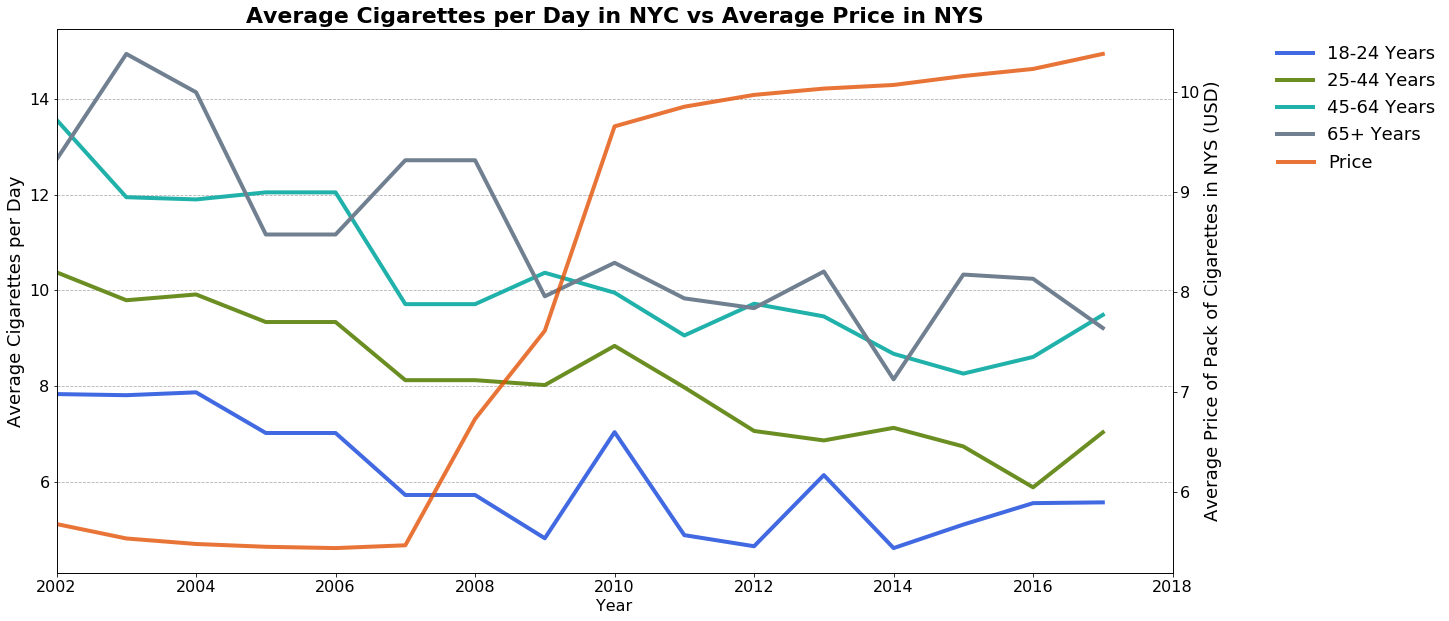

In [493]:
fig, ax1 = plt.subplots(figsize = (20,10))


#graph average cigs per day for each age group(18-24 yrs, 25-44 yrs, 45-64 yrs, and 65+ yrs)
ax1.plot(final["Cigs per Day "].loc[1.0].fillna(method='ffill'), label = "18-24 Years", linewidth = 4, color = "#4169E1")
ax1.plot(final["Cigs per Day "].loc[2.0].fillna(method='ffill'), label = "25-44 Years", linewidth = 4, color = "#6B8E23")
ax1.plot(final["Cigs per Day "].loc[3.0].fillna(method='ffill'), label = "45-64 Years", linewidth = 4, color= "#20B2AA")
ax1.plot(final["Cigs per Day "].loc[4.0].fillna(method='ffill'), label = "65+ Years", linewidth = 4, color = "#708090")
#use fillna to fill in for 2006 and 2008 that don't have cigs per day data 

ax1.set_title("Average Cigarettes per Day in NYC vs Average Price in NYS", fontsize = 22, fontweight = "bold") #set title
ax1.set_xlabel("Year", fontsize = 16) #x label
ax1.set_ylabel("Average Cigarettes per Day", fontsize = 18) #left-axis y label

ax1.legend(frameon = False, fontsize = 18, bbox_to_anchor=(1.25, 1))#create legend and move to side of graph
ax1.grid(axis = "y", linestyle = "--")#add gridlines

ax1.set_xlim(2002,2018) #set limits for x axis 
plt.xticks(size = 16) #set tick size
plt.yticks(size = 16)

ax2 = ax1.twinx() #second y-axis for price 

ax2.plot(nyprices["Price"], label = "Price", linewidth = 4, color = "#E35205", alpha = 0.8) #plot price
ax2.legend(frameon = False, fontsize = 18, bbox_to_anchor=(1.194, .8)) #second legend underneath the first 

ax2.set_ylabel("Average Price of Pack of Cigarettes in NYS (USD)", fontsize = 18) #right-axis label
plt.yticks(size = 16)


#plt.savefig("Cigs per Day", bbox_inches = "tight", dip = 1200) #save as .png
plt.show()

The second graph shown below is the percentage of smokers out of the total population of each age group, with the percentage on the left hand axis. On the right hand axis, again, is the average price of cigarettes, with the price also plotted over the 2002- 2017 timeframe. 


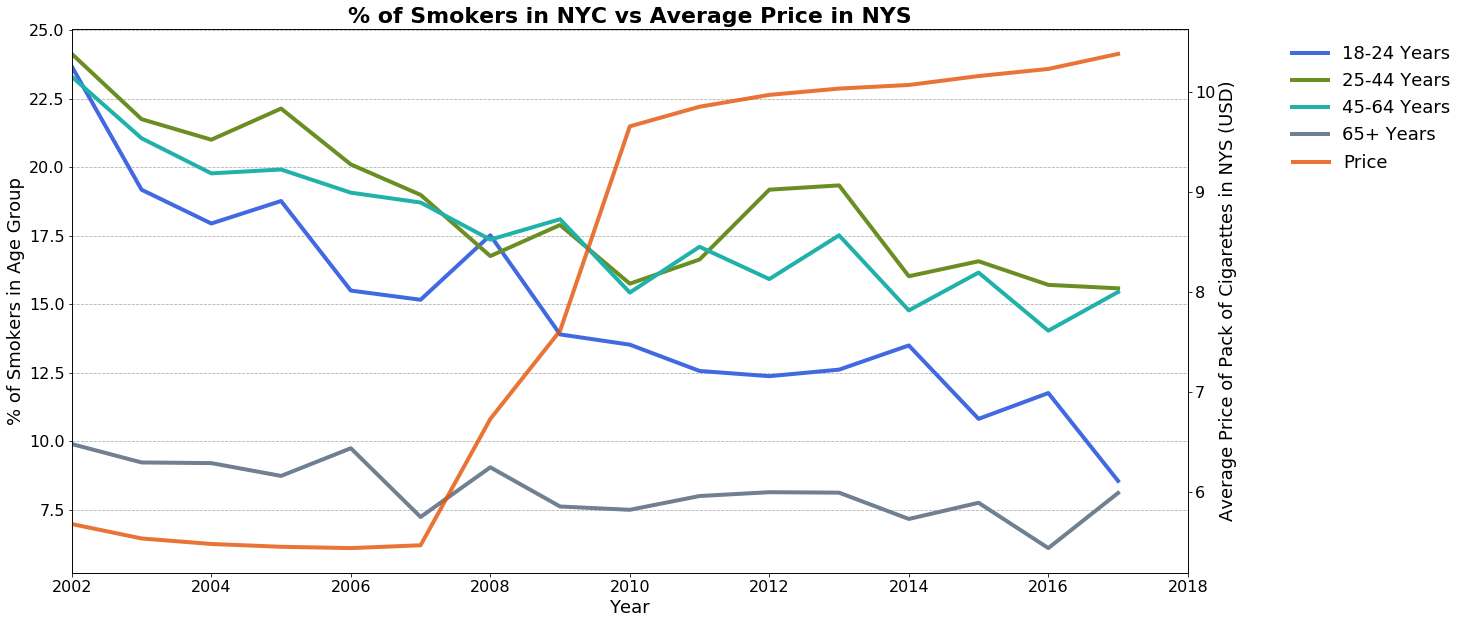

In [494]:
fig, ax1 = plt.subplots(figsize = (20,10))


#graph the % of smokers for each age group (18-24 yrs, 25-44 yrs, 45-64 yrs, and 65+ yrs)
ax1.plot((final["% Smokers "].loc[1.0]), label = "18-24 Years", linewidth = 4, color = "#4169E1")
ax1.plot((final["% Smokers "].loc[2.0]), label = "25-44 Years", linewidth = 4, color = "#6B8E23")
ax1.plot((final["% Smokers "].loc[3.0]), label = "45-64 Years", linewidth = 4, color= "#20B2AA")
ax1.plot((final["% Smokers "].loc[4.0]), label = "65+ Years", linewidth = 4, color = "#708090")
#use fillna to fill in for 2006 and 2008 that don't have cigs per day data 

ax1.set_title("% of Smokers in NYC vs Average Price in NYS", fontsize = 22, fontweight = "bold") #set title
ax1.set_xlabel("Year", fontsize = 18) #set x-axis label
ax1.set_ylabel("% of Smokers in Age Group", fontsize = 18) #left-axis label

ax1.legend(frameon = False, fontsize = 18, bbox_to_anchor=(1.25, 1)) #create legend and move to side of graph

ax1.grid(axis = "y", linestyle = "--")  #add gridlines

ax1.set_xlim(2002,2018) #limits for x axis
plt.xticks(size = 16) #set size for ticks
plt.yticks(size = 16)

ax2 = ax1.twinx() #add second axis for price 

ax2.plot(nyprices["Price"], label = "Price", linewidth = 4, color = "#E35205", alpha = 0.8) #plot price on second axis
ax2.legend(frameon = False, fontsize = 18, bbox_to_anchor=(1.194, .8)) #put legend underneath the first one 

ax2.set_ylabel("Average Price of Pack of Cigarettes in NYS (USD)", fontsize = 18) #right-side axis label
plt.yticks(size = 16)


#plt.savefig("% Smokers", bbox_inches = "tight", dip = 1200) #save as .png
plt.show()

### Results: 

From the above graphs, we can see that both the percentage of smokers and the average cigarettes per day have gone down across all age groups, while the price of a pack of cigarettes has gone up dramatically. The price of a pack of cigarettes increased significantly from 2007 to 2010 as NYS changed the price minimum, and the continued increase is from NYC increasing its cigarette tax. However, it is unclear as to whether these changes came from the increase in price, since NYC has had other smoking policies go into effect over the timeframe. For example, for the 18-24, 25-44, and 45-64 age groups, the % of smokers decreased dramatically right after 2002, when the Clean Air Act went into effect. Unfortunately, the CHS was first taken in 2002 so it is unclear what direction smoking rates and amounts were moving before the Clean Air Act. As the CHS continues to take survey data on smoking, effects of specific policies will likely be clearer. 

One interesting outcome we can see in the percentage of smokers graph is that the 18-24 age group has decreased the most- so whether this is as a result of increasing prices or restrictive smoking laws, we can see that the youngest age group is most responsive to anti-smoking policies, and similarly that the oldest age group is the least responsive. 